In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

In [3]:
phantom_data=scipy.io.loadmat('Bay1.mat')

In [5]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]
cleaned = phantom_data["NoiseNet_Cleaned"]

In [6]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)
gt_skew = sp.stats.skew(gt,axis=1)
fmri_skew = sp.stats.skew(fmri,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

7 49


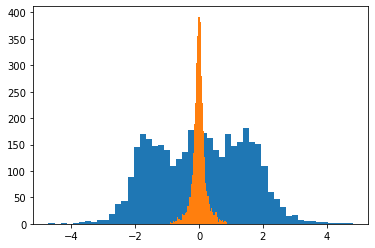

In [7]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

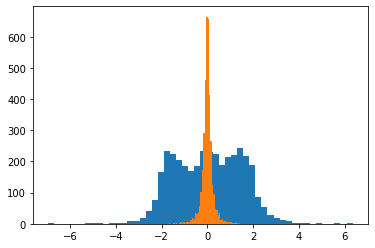

In [8]:
skew_idx = np.argsort(gt_nooutliers)
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

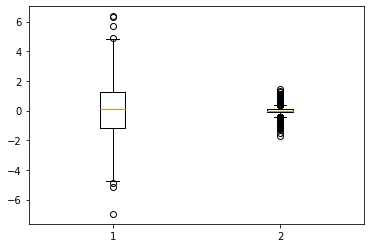

In [9]:
_ = plt.boxplot([gt_skew,fmri_skew])

In [10]:
gt_norm = (gt - gt_mean[:,np.newaxis])/gt_std[:,np.newaxis]
fmri_norm = (fmri - fmri_mean[:,np.newaxis])/fmri_std[:,np.newaxis]

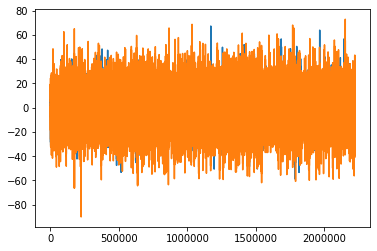

In [11]:
idx = 800
gt_data = gt[skew_idx].flatten()
fmri_data = fmri[skew_idx].flatten()
plt.plot(gt_data)
plt.plot(fmri_data)

In [12]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [11:15<00:00,  5.93draws/s] 
The acceptance probability does not match the target. It is 0.9119766007514859, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855635230433104, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9070960074924689, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
#pm.traceplot(posterior_2)

In [13]:
pm.summary(posterior_2)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,7.513521,0.004120,0.000126,7.505377,7.521432,1195.001415,1.000405
ampl_noise,0.767414,0.002091,0.000063,0.763143,0.771048,1045.524131,1.000491


In [16]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/thermal:",sigma_mult**2/sig_total**2)

sigma mult: 3.6108242020427483
sigma thermal: 7.513521241450029
sigma thermal normalized 1.5968607012109408
sigma thermal normalized error 0.0008756336267408942
sigma total noise fitted: 8.336129369424304
sigma total (fmri-gt): 8.282203707789558
sigma GT: 4.705182634748498
signal to noise ratio: 0.3185840869289582
sigma multi/thermal: 0.1876220157955559


In [ ]:
# here is a more realistic model
#with pm.Model() as multi_noise2:
#    sigma1 = pm.Uniform('sigma1',0,5)
#    ampl1 = pm.Uniform('ampl1',0,5)
#    noise_thermal = pm.Normal('noise_thermal',mu=gt_data, sigma=sigma1,shape=len(gt_data))
#    noise_multi = pm.Normal('noise_multi',mu=0, sigma=ampl1*np.abs(gt_data),shape=len(gt_data))
    
#    fmri = pm.Deterministic('fmri', noise_thermal + noise_multi)
#    fmri_observed = pm.Normal('fmri_observed', mu=fmri, tau=10000,observed=fmri_data)

#    posterior = pm.sample(2000, tune=1000)

In [ ]:
#pm.traceplot(posterior['sigma1'])

In [ ]:
#pm.traceplot(posterior['ampl1'])

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


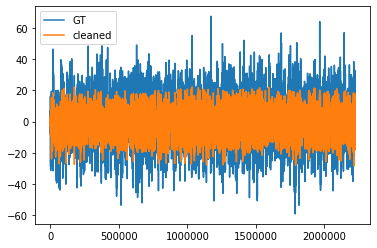

In [21]:
idx = 800
gt_data = gt[skew_idx].flatten()
cleaned_data = cleaned[skew_idx].flatten()
plt.plot(gt_data,label="GT")
plt.plot(cleaned_data,label="cleaned")
plt.legend()

In [23]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    ampl_signal = pm.Uniform('ampl_signal',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=ampl_signal*gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=cleaned_data)

    posterior_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_signal, ampl_noise, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [20:05<00:00,  3.32draws/s]  
The acceptance probability does not match the target. It is 0.915229685326098, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897212666833544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9138261209710767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9389066700565343, but should be close to 0.8. Try to increase the number of tuning steps.


In [25]:
pm.summary(posterior_3)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,1.000511,0.000716,0.000017,0.999024,1.001882,1600.955889,0.999743
ampl_noise,0.384512,0.000395,0.000009,0.383820,0.385326,1674.071811,0.999130
ampl_signal,0.171447,0.000433,0.000014,0.170650,0.172301,807.221630,0.999615


In [24]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_3['sigma1'])
amp_noise = np.mean(posterior_3['ampl_noise'])
amp_signal = np.mean(posterior_3['ampl_signal'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(amp_signal*gt_data))
print("sigma thermal normalized error",np.std(posterior_3['sigma1'])/np.std(amp_signal*gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(cleaned_data-amp_signal*gt_data))
print("sigma GT:",np.std(amp_signal*gt_data))
print("signal to noise ratio:",np.std(amp_signal*gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/thermal:",sigma_mult**2/sig_total**2)

sigma mult: 1.809199603345892
sigma thermal: 1.0005107045657344
sigma thermal normalized 1.2402701498972155
sigma thermal normalized error 0.0008880266398778976
sigma total noise fitted: 2.0674198593168143
sigma total (fmri-gt): 2.0000912713434635
sigma GT: 0.8066877241612639
signal to noise ratio: 0.15224867745371637
sigma multi/thermal: 0.7658004201237878
